In [1]:
#### 
import matplotlib.pyplot as plt
import thejoker.units as xu
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import corner
import math 
import h5py
import csv
import os


from astropy.visualization.units import quantity_support
from sklearn.metrics import mean_squared_error
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from os.path import join
from tqdm import tqdm

In [2]:
# Configurar el estilo de fuente global a 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif']

In [3]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [4]:
columns = ["Star","Date","RV","err_RV","S/N"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [5]:
Estrella["Nrich_1"]

,Star,Date,RV,err_RV,S/N
0,TYC4686-2039-1,2.459825e+06,147.1074,0.0208,27
1,TYC4686-2039-1,2.459874e+06,148.0102,0.0326,19
2,TYC4686-2039-1,2.459875e+06,148.9813,0.0673,15
3,TYC4686-2039-1,2.459875e+06,149.0065,0.0832,14


In [6]:
# Obtén la ruta absoluta
file_path = os.path.abspath('news_RV/Nrich1_2M01575297-0316508.csv')
print(file_path)

# Luego intenta leer el archivo
df = pd.read_csv(file_path)
df_ordenado = df.sort_values(by='JD')
df_ordenado = df_ordenado[df_ordenado['STARFLAG']==0].reset_index(drop=True)
df_ordenado

/home/alexandert/Docs_Jupyter/9.Joven_Investigador/Nrich/news_RV/Nrich1_2M01575297-0316508.csv


,APOGEE_ID,TARGET_ID,MJD,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,VRELERR,VHELIO
0,2M01575297-0316508,2M01575297-0316508,57652,102.29,0,NaN,2016-09-21T08:32:57.948,2.457653e+06,0.039750,156.376575
1,2M01575297-0316508,2M01575297-0316508,57653,155479.00,0,NaN,2016-09-22T08:52:09.797,2.457654e+06,0.025858,156.350130
2,2M01575297-0316508,2M01575297-0316508,57656,159966.00,0,NaN,2016-09-25T08:48:20.623,2.457657e+06,0.025280,156.283356
3,2M01575297-0316508,2M01575297-0316508,57673,141179.00,0,NaN,2016-10-12T07:33:35.573,2.457674e+06,0.028642,156.352379


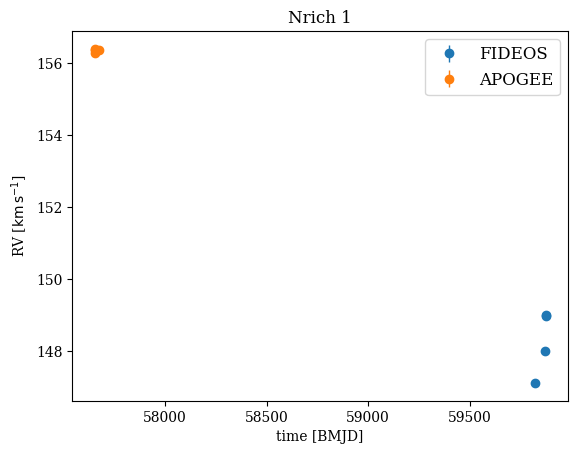

In [7]:
fideos_data = tj.RVData(
    t=np.array(Estrella["Nrich_1"]["Date"])-2400000.5,
    rv=np.array(Estrella["Nrich_1"]["RV"]) * u.km/u.s,
    rv_err=np.array(Estrella["Nrich_1"]["err_RV"]) * u.km/u.s,
)

apogee_data = tj.RVData(
    t=np.array(df_ordenado["JD"])-2400000.5,
    rv=np.array(df_ordenado["VHELIO"])* u.km/u.s,
    rv_err=np.array(df_ordenado["VRELERR"])* u.km/u.s,
)

data = [apogee_data, fideos_data]
for d, name in zip([fideos_data, apogee_data], ["FIDEOS", "APOGEE"]):
    d.plot(color=None, label=name)
plt.title("Nrich 1", fontsize = 12)
plt.legend(fontsize=12)
plt.show()

In [8]:
t = np.concatenate((np.array(df_ordenado["JD"]),np.array(Estrella["Nrich_1"]["Date"])))-2400000.5
rv = np.concatenate((np.array(df_ordenado["VHELIO"]),np.array(Estrella["Nrich_1"]["RV"]))) * u.km/u.s
err = np.concatenate((np.array(df_ordenado["VRELERR"]),np.array(Estrella["Nrich_1"]["err_RV"]))) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)

In [9]:
data

<RVData: 8 epochs>

### The Joker | Con wave

Estos datos fueron calculados teniendo en cuenta los siguientes parámetros.

$$P_{min} = 2 ~días$$
$$P_{max} = e^8 ~días$$
$$sigma\_K0=30 * u.km / u.s$$
$$sigma\_v=100 * u.km / u.s$$

Además el número de priors que se logró establecer es $J=2^{25}$

In [10]:
samples = tj.JokerSamples.read("TJ_samples_Nrich1.hdf5")
samples.tbl

P,e,omega,M0,s,K,v0
d,,rad,rad,km / s,km / s,km / s
float64,float64,float64,float64,float64,float64,float64
284.06968034083775,0.8538464405848948,-2.8516590524599232,-1.3843039384140188,0.0,32.073942431223145,150.50611559661587


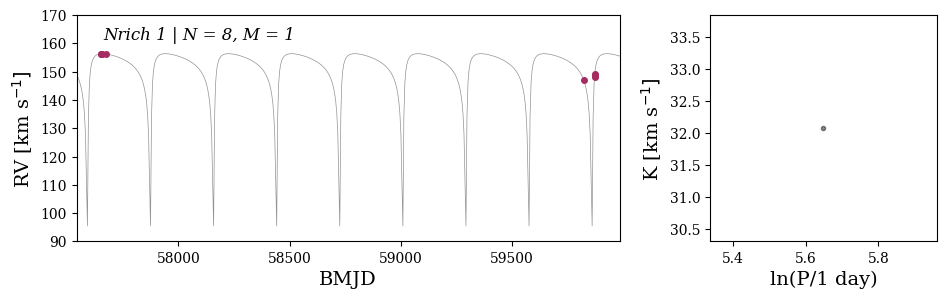

In [11]:
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(90,170)
f_ax1.text(0.05, 0.95, f'Nrich 1 | N = {len(t)}, M = {len(samples)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

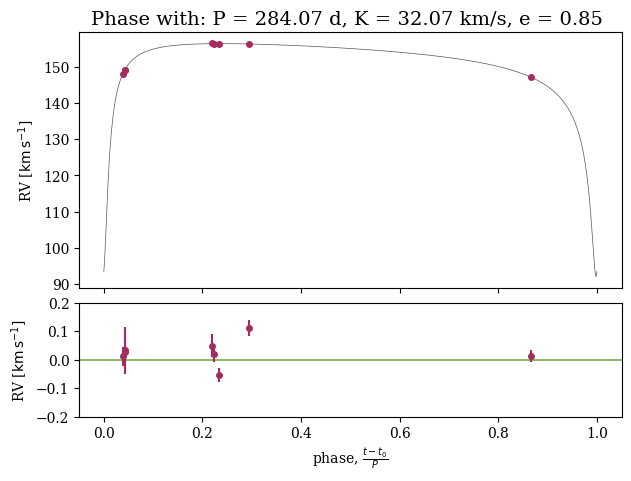

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Phase with: P = {round(float(samples['P'].value),2)} d, K = {round(float(samples['K'].value),2)} km/s, e = {round(float(samples['e'].value),2)} ", fontsize = 14)

    
_ = tj.plot_phase_fold(samples, data=data,ax=ax[0],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(samples, data, ax=ax[1], residual=True, data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

Número de muestras mínimas establecidas (estas serían los datos resultantes, los aprovados, los posteriores admitidos)

$$M_{min} = 128$$

Resolución del periodo:

$$Δ =  \frac{4P^2}{2\pi T}$$

Los tres resultados posibles son los siguientes:
1. $M >> M_{min}$ muestras sobreviven al rechazo. En este caso, hemos terminado.
   
3. $M < M_{min}$ muestras sobreviven al rechazo, y estas muestras tienen una varianza de raíz (rms) en el parámetro de periodo P que es menor que Δ (es decir, no dan ninguna indicación de ambigüedad de periodo). En este caso suponemos que la pdf posterior es efectivamente unimodal, y utilizamos las muestras supervivientes (o muestra) para inicializar un muestreo MCMC utilizando el paquete emcee (Foreman-Mackey et al. 2013).
   
5. $M < M_{min}$ muestras sobreviven al rechazo, y estas muestras abarcan un intervalo de periodos mayor que Δ. En este caso, iteramos el procedimiento de muestreo de rechazo: generamos nuevos muestreos pdf previos y muestreos de rechazo hasta que el número de muestras supervivientes sea mayor que Mmin. Esto es costoso.

In [13]:
P = np.median(samples["P"])
T = (t.max()-t.min())*u.d
Δ = (4*P**2)/(2*np.pi*T)
print("Δ = ",Δ) 

Δ =  23.120581841229193 d


In [14]:
root_var = np.sqrt(np.var(samples["P"]))
print("root variance = ",root_var)

root variance =  0.0 d


In [15]:
if (Δ>root_var):
    print("Se debe realizar el paso 2, es decir:")
    print("En este caso suponemos que la pdf posterior es efectivamente unimodal, y utilizamos las muestras supervivientes (o muestra) para inicializar un muestreo MCMC utilizando el paquete emcee.")
elif (Δ<root_var):
    print("Se debe realizar el paso 3, es decir:")
    print("En este caso, iteramos el procedimiento de muestreo de rechazo: generamos nuevos muestreos pdf previos y muestreos de rechazo hasta que el número de muestras supervivientes sea mayor que Mmin.")

Se debe realizar el paso 2, es decir:
En este caso suponemos que la pdf posterior es efectivamente unimodal, y utilizamos las muestras supervivientes (o muestra) para inicializar un muestreo MCMC utilizando el paquete emcee.


In [16]:
prior = tj.JokerPrior.default(
    P_min=2 * u.day,
    P_max=2980 * u.day,
    sigma_K0=30 * u.km / u.s,
    sigma_v=100 * u.km / u.s,
)
rnd = np.random.default_rng(seed=8675309)
joker = tj.TheJoker(prior, rng=rnd)

In [17]:
# with prior.model:
#     mcmc_init = joker.setup_mcmc(data, samples)
#     trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)

In [18]:
# az.summary(trace, var_names=prior.par_names)

In [19]:
# mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
# mcmc_samples.wrap_K()
# mcmc_samples.write("TJ_mcmc_samples_Nrich1.hdf5", overwrite=False)

In [20]:
mcmc_samples = tj.JokerSamples.read("TJ_mcmc_samples_Nrich1.hdf5")
mcmc_samples

<JokerSamples [P, e, omega, M0, s, K, v0, ln_posterior, ln_likelihood, ln_prior] (715 samples)>

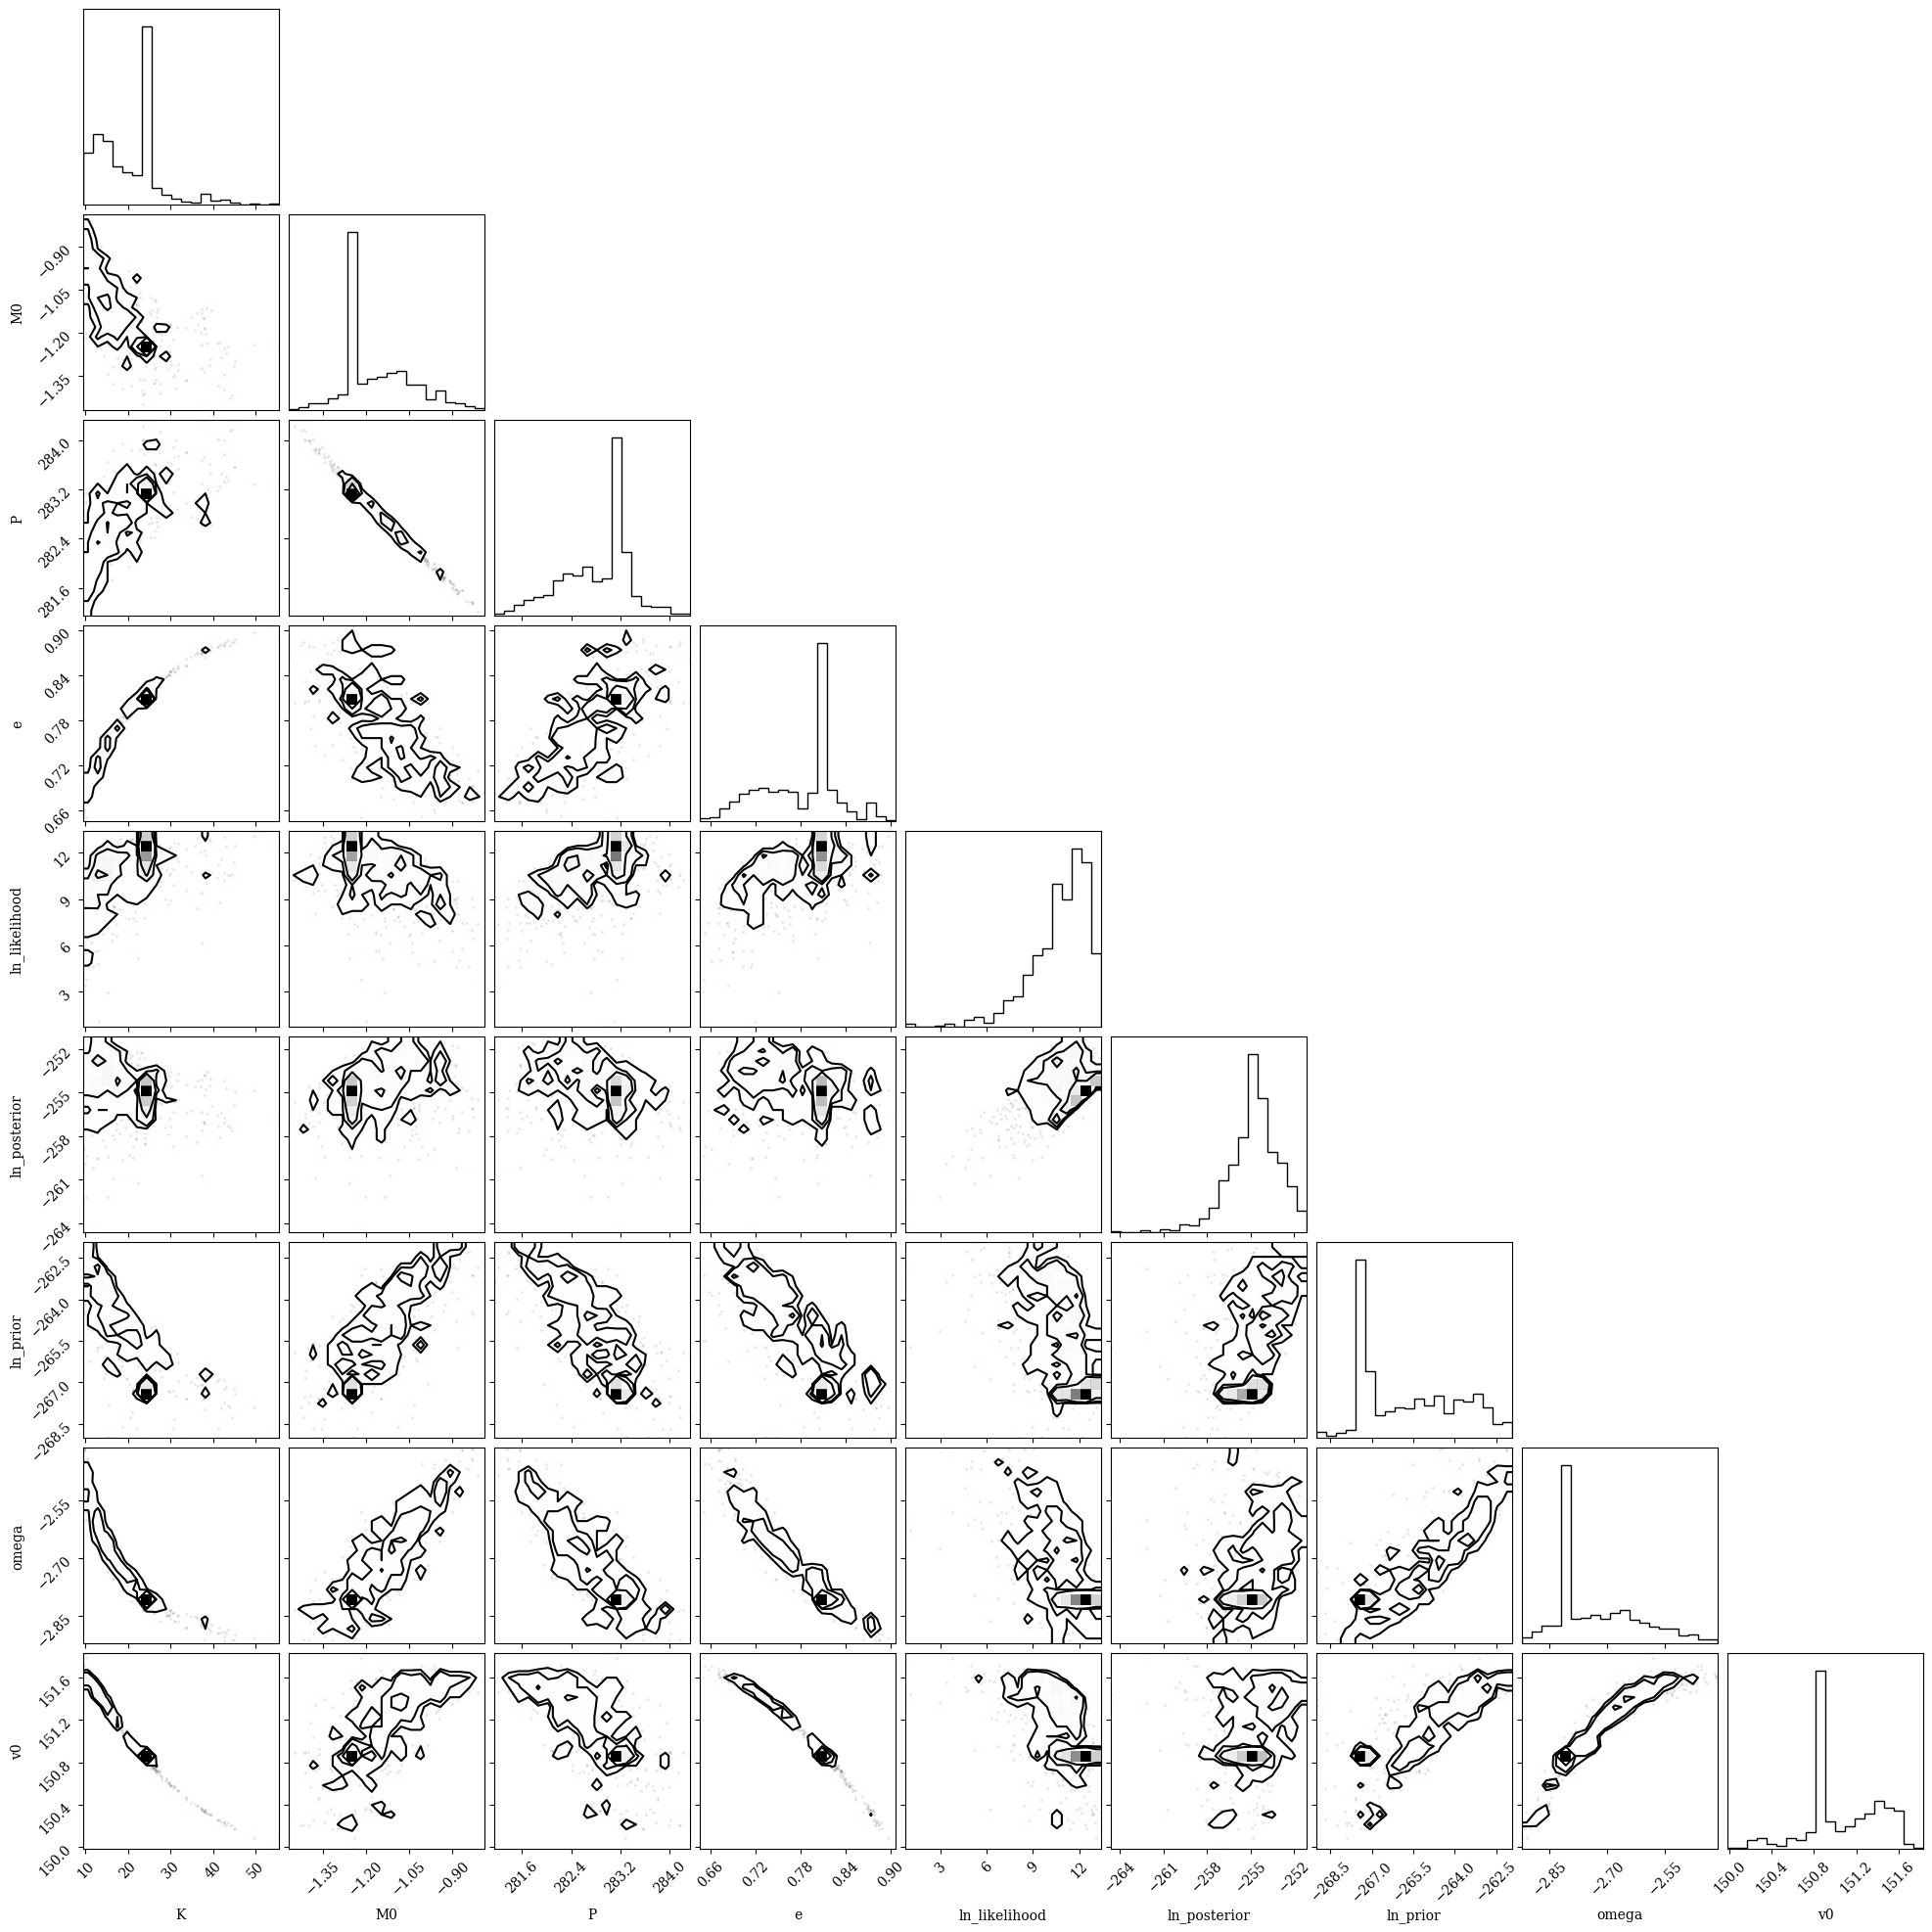

In [21]:
df = mcmc_samples.tbl.to_pandas()
colnames = mcmc_samples.par_names
colnames.pop(colnames.index("s"))
_ = corner.corner(df[colnames])

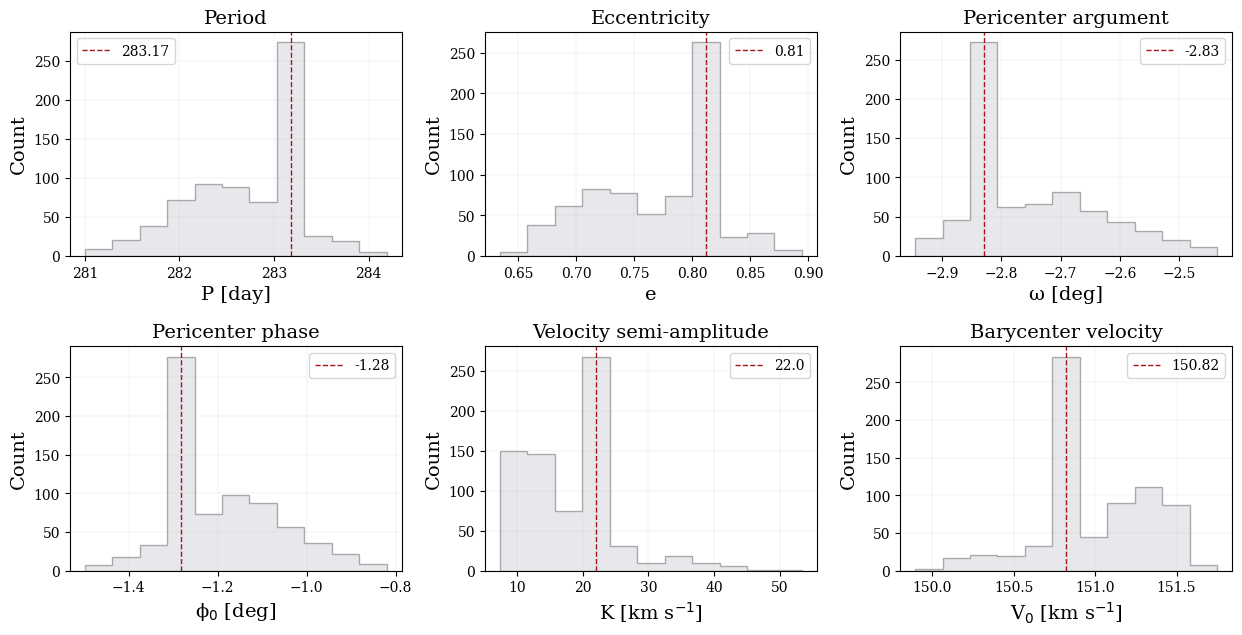

In [22]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []

fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    ax.set_title(title[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(mcmc_samples[variables[i]], bins = "sturges", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(pico_mas_alto)
    # Agregar una línea vertical en el pico más alto
    ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

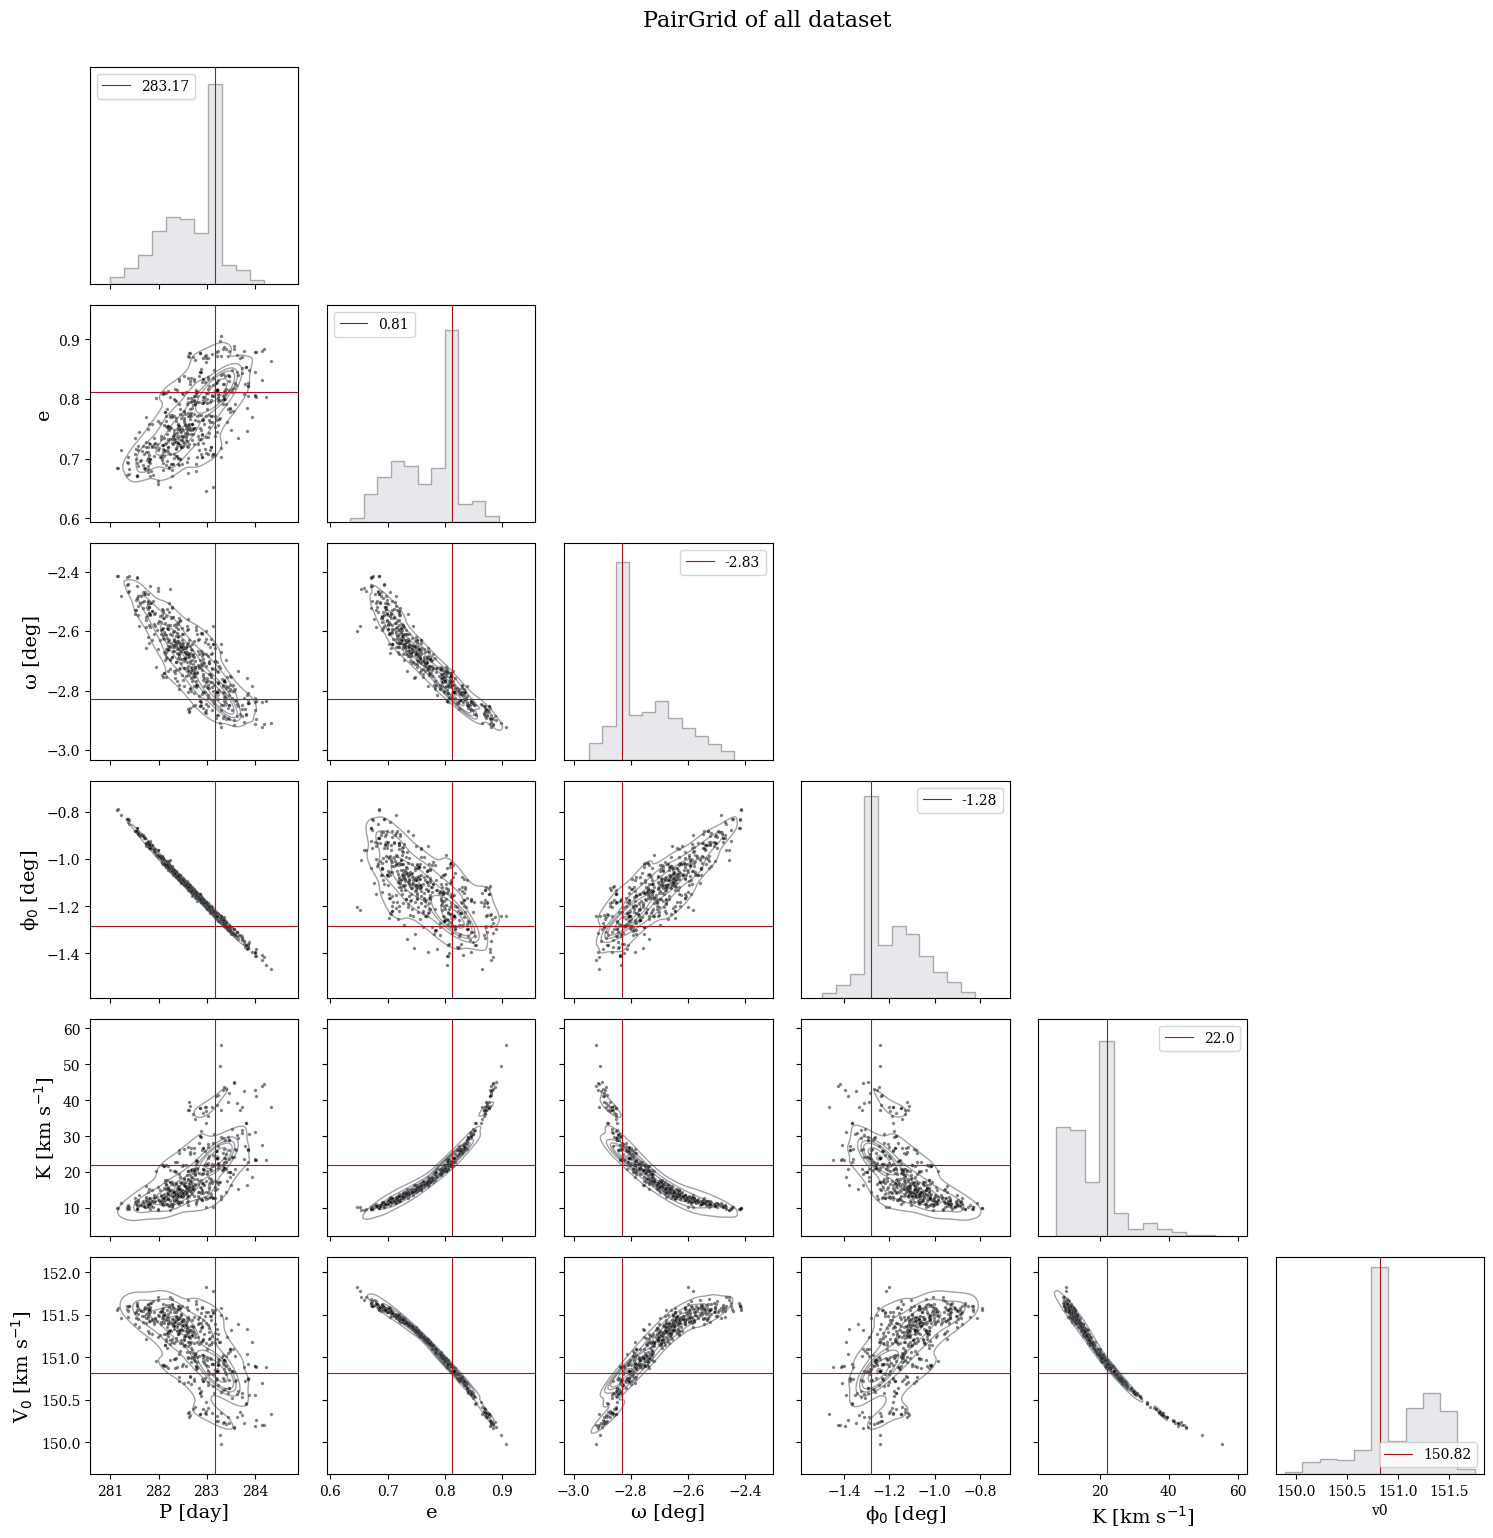

In [23]:
# Crear un gráfico de correlación utilizando pairplot
df = mcmc_samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P", "e", "omega", "M0", "K", "v0"],
            y_vars=["P", "e", "omega", "M0", "K", "v0"],
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = "sturges", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1, alpha = 0.5)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 6, alpha = 0.5, color="k")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)

# Agregar líneas verticales y horizontales en los gráficos de densidad fuera de la diagonal
for i, x_var in enumerate(variables):
    for j, y_var in enumerate(variables):
        if i != j:
            ax = g.axes[j, i]
            if ax is not None:
                ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.axhline(y=picos[j], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.set_xlabel(xlabel[i], fontsize = 14)
                ax.set_ylabel(xlabel[j], fontsize = 14)

# Agregar líneas verticales personalizadas en las diagonales

for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth = 0.8, label = f"{round(picos[i],2)}")
    ax.legend()
    
ax.set_ylabel(xlabel[-1], fontsize = 14)

# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02, fontsize = 16)
plt.show

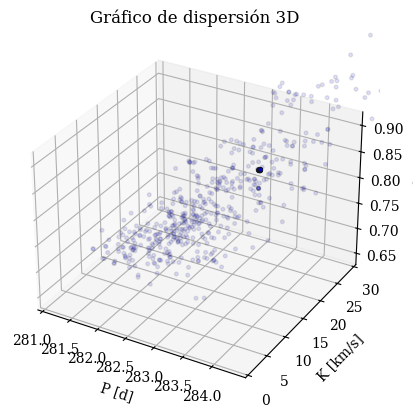

In [24]:
# Datos de muestra
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("P [d]")
ax.set_ylabel("K [km/s]")
ax.set_zlabel("e")
ax.set_ylim(0,30)
plt.title("Gráfico de dispersión 3D")

# Gráfico de dispersión 3D
ax.scatter(mcmc_samples["P"], mcmc_samples["K"], mcmc_samples["e"],marker="o", s=7, color = "b", alpha=0.12, ec='#212325')

plt.show()

In [25]:
picos

[283.1747900997007,
 0.8117733015919348,
 -2.829738149616276,
 -1.282598168144484,
 21.999369851248858,
 150.8217479368601]

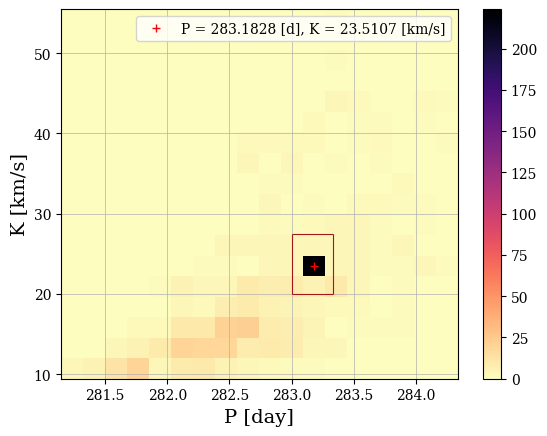

Coordenadas del valor más significativo:
x = 283.182845326539
y = 23.510730086472343


In [26]:
bin = 18

# Calcula el histograma bidimensional
hist, x_edges, y_edges = np.histogram2d(x=mcmc_samples['P'].value, y=mcmc_samples['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=mcmc_samples['P'].value, y=mcmc_samples['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
fig.colorbar(h[3], ax=ax)
ax.plot(x_max_density, y_max_density, "+", color="red", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("P [day]", fontsize = 14)
ax.set_ylabel("K [km/s]", fontsize = 14)

xmin = 283.0
xmax = 283.25+0.25/3
ymin = 20
ymax = 20+3*5/2

ax.vlines(x=xmin, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.vlines(x=xmax, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)

ax.hlines(y=ymin ,xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.hlines(y=ymax, xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)

plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [27]:
mask_P = (mcmc_samples["P"].value>=xmin) & (mcmc_samples["P"].value<=xmax)

Filtrado = mcmc_samples[mask_P]
mask_K = (Filtrado["K"].value>=ymin) & (Filtrado["K"].value<=ymax)

Filtrado = Filtrado[mask_K]

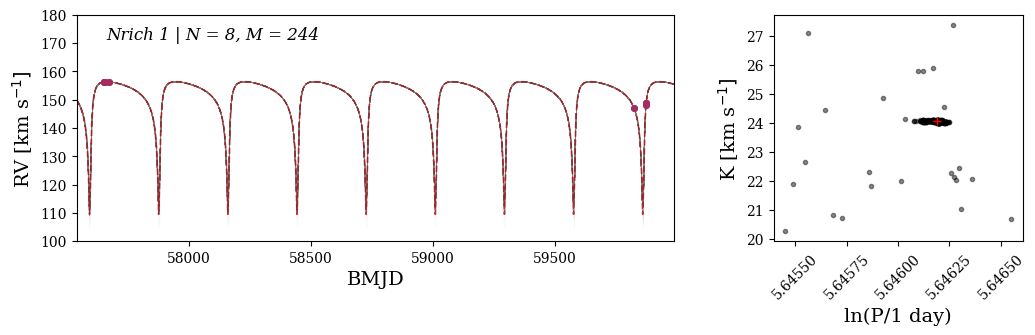

In [51]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
f_ax2.scatter(np.log(Filtrado['P'].value), Filtrado['K'].value,marker='.', color='k', alpha=0.45)
f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["K"], "+", color = "red" )

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(100,180)

# Ajustar el tamaño de los ticks para mejorar la legibilidad
plt.xticks(rotation=45)
f_ax1.text(0.05, 0.95, f'Nrich 1 | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

In [40]:
Filtrado.median_period()["P"],Filtrado.median_period()["K"]

(<Quantity [283.21056894] d>, <Quantity [24.05330568] km / s>)

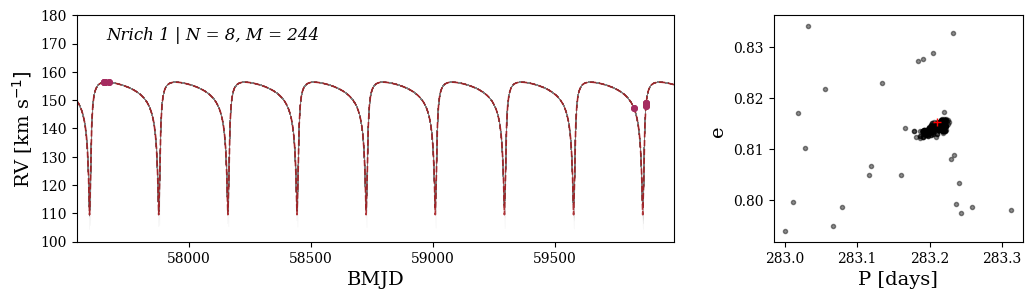

In [41]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
f_ax2.scatter(Filtrado['P'].value, Filtrado['e'].value,marker='.', color='k', alpha=0.45)
f_ax2.plot(Filtrado.median_period()["P"],Filtrado.median_period()["e"], "+", color = "red" )

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("P [days]",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.set_ylim(100,180)
f_ax1.text(0.05, 0.95, f'Nrich 1 | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

In [31]:
Filtrado.median_period()["P"],Filtrado.median_period()["e"]

(<Quantity [283.21056894] d>, <Quantity [0.81530624]>)

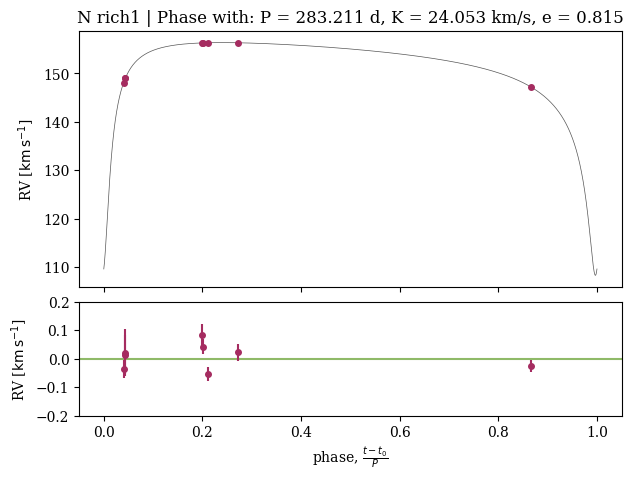

In [33]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"N rich1 | Phase with: P = {round(float(Filtrado.median_period()['P'].value),3)} d, K = {round(float(Filtrado.median_period()['K'].value),3)} km/s, e = {round(float(Filtrado.median_period()['e'].value),3)}",fontsize = 12)

    
_ = tj.plot_phase_fold(Filtrado.median_period(), data=data,ax=ax[0],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(Filtrado.median_period(), data, ax=ax[1], residual=True, data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt
# from astropy import units as u
# from astropy.time import Time

# # Definir los elementos de Kepler
# P = 283.20 * u.day
# a = 0.36 * u.AU
# e = 0.81
# omega = -160.91 * u.deg
# i = 90.00 * u.deg
# Omega = 0.00 * u.deg
# t0 = Time(0, format='jd')  # Tiempo de referencia arbitrario para el ejemplo

# # Convertir ángulos a radianes
# omega_rad = omega.to(u.rad).value
# i_rad = i.to(u.rad).value
# Omega_rad = Omega.to(u.rad).value

# # Definir un rango de tiempo para plotear la órbita
# t = np.linspace(0, P.to(u.day).value, 1000) * u.day
# t = t0 + t  # Tiempo en formato astropy Time

# # Calcular la anomalía media
# n = 2 * np.pi / P.to(u.day).value  # Módulo angular
# M = n * (t - t0).to(u.day).value  # Anomalía media en radianes

# # Resolver la anomalía excéntrica usando el método de Newton-Raphson
# E = np.zeros_like(M)
# for idx, M_val in enumerate(M):
#     E_guess = M_val  # Aprox. inicial
#     for _ in np.arange(10):  # Iteraciones de Newton-Raphson
#         f = E_guess - e * np.sin(E_guess) - M_val
#         f_prime = 1 - e * np.cos(E_guess)
#         E_guess -= f / f_prime
#     E[idx] = E_guess

# # Calcular coordenadas en el plano orbital
# x_orbital = a * (np.cos(E) - e)
# y_orbital = a * np.sqrt(1 - e**2) * np.sin(E)

# # Aplicar las rotaciones para obtener la órbita en coordenadas eclípticas
# x_rot = x_orbital * (np.cos(Omega_rad) * np.cos(omega_rad) - np.sin(Omega_rad) * np.sin(omega_rad) * np.cos(i_rad)) - y_orbital * (np.sin(Omega_rad) * np.cos(omega_rad) + np.cos(Omega_rad) * np.sin(omega_rad) * np.cos(i_rad))
# y_rot = x_orbital * (np.sin(Omega_rad) * np.cos(omega_rad) + np.cos(Omega_rad) * np.sin(omega_rad) * np.cos(i_rad)) + y_orbital * (np.cos(Omega_rad) * np.cos(omega_rad) - np.sin(Omega_rad) * np.sin(omega_rad) * np.cos(i_rad))

# # Dibujar la órbita
# plt.figure(figsize=(8, 8))
# plt.plot(x_rot, y_rot, label='Órbita Kepleriana')
# plt.scatter(0, 0, color='orange', s=100, label='Centro de masa')
# plt.xlabel('x (AU)')
# plt.ylabel('y (AU)')
# plt.legend()
# plt.title('Órbita Kepleriana reconstruida')
# plt.grid(True)
# plt.axis('equal')
# plt.show()



In [35]:
# orbit.elements

#### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

In [36]:
# En nuestro caso
def Calculo_Masa(P,K,e):
    P = float(P.value)*u.day
    e = float(e.value)
    K = float(K.to("m/s").value)*u.m/u.s
    
    print("P =",P)
    print("e =",e)
    print("K =",K)
    
    def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
    
    # Función de masa
    f_value = f(P,e,K)
    
    
    M1 = 0.8*u.M_sun
    sini =  1
    
    # Ejemplo de uso
    def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices
        
    a = (sini)**3
    b = -f_value.value
    c = -2*M1.value*f_value.value
    d = -M1.value**2*f_value.value
    
    raices = resolver_ecuacion_cubica(a, b, c, d)
    print("Las raíces de la ecuación son:", raices)
    
    M2 = raices[0].real*u.M_sun
    M_jupiter = 1.898e27*u.kg
    print("La masa del objeto en M_Sun, M2 = ",M2)
    print("La masa del objeto en kg, M2 = ",M2.to("kg"))
    print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
    print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))
    return M2

In [37]:
M2 = Calculo_Masa(Filtrado.median_period()["P"],Filtrado.median_period()["K"],Filtrado.median_period()["e"])

P = 283.21056893636387 d
e = 0.8153062411419565
K = 24053.305677843375 m / s
Las raíces de la ecuación son: [ 0.51578181+0.j         -0.21826307+0.22517641j -0.21826307-0.22517641j]
La masa del objeto en M_Sun, M2 =  0.5157818139256978 solMass
La masa del objeto en kg, M2 =  1.0255856499364028e+30 kg
La masa del objeto en M_J, M2 =  540.3152413575881 jupiterMass
La masa del objeto en M_E, M2 =  171727.53221949938 earthMass


Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [38]:
for i in variables:
    print(f"{i} = ",Filtrado.median_period()[i])

P =  [283.21056894] d
e =  [0.81530624]
omega =  [-2.809031] rad
M0 =  [-1.24492828] rad
K =  [24.05330568] km / s
v0 =  [150.84723023] km / s


In [39]:
M2

<Quantity 0.51578181 solMass>

In [40]:
def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
M1 = 0.8*u.M_sun
sini =  1

In [41]:
def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices

In [42]:
P_all = Filtrado["P"]
e_all = Filtrado["e"]
K_all = Filtrado["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all

<Quantity [0.0628947 , 0.05978594, 0.05669984, 0.05668737, 0.0890126 ,
           0.06837093, 0.09773131, 0.08241695, 0.08048665, 0.07923884,
           0.06849337, 0.06787241, 0.06480769, 0.06624582, 0.06802353,
           0.07000795, 0.05908857, 0.07625782, 0.08300688, 0.06634405,
           0.05483985, 0.06527656, 0.10213688, 0.08905645, 0.08910681,
           0.07905828, 0.07905828, 0.07905828, 0.07905828, 0.07897225,
           0.07897225, 0.07881728, 0.07895494, 0.07927754, 0.0794579 ,
           0.07952283, 0.07952283, 0.07952283, 0.07952283, 0.07952283,
           0.07874635, 0.07997164, 0.07997164, 0.07925567, 0.07924474,
           0.07924474, 0.07924474, 0.07912625, 0.07912625, 0.07912625,
           0.07924636, 0.07924636, 0.07896936, 0.07922452, 0.07922452,
           0.07949675, 0.07949675, 0.07949675, 0.07949675, 0.07977888,
           0.07961018, 0.07968878, 0.07968878, 0.07968971, 0.07982075,
           0.08005895, 0.08005895, 0.08005895, 0.08026575, 0.08026575,
      

In [43]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).value))

In [44]:

P_all_full = mcmc_samples["P"]
e_all_full = mcmc_samples["e"]
K_all_full = mcmc_samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [0.20590732, 0.22632333, 0.0628947 , 0.05978594, 0.05669984,
           0.05668737, 0.04103182, 0.02706787, 0.02711945, 0.02815325,
           0.04041311, 0.10658551, 0.12014233, 0.11898583, 0.0890126 ,
           0.07348706, 0.066021  , 0.05354537, 0.04973901, 0.07936237,
           0.05566678, 0.06190361, 0.05628243, 0.05518549, 0.12499939,
           0.13201906, 0.0539966 , 0.05154472, 0.04974279, 0.03867405,
           0.03737031, 0.03867338, 0.0480438 , 0.04880944, 0.0588062 ,
           0.05714977, 0.06837093, 0.0916039 , 0.08185665, 0.03746571,
           0.01068916, 0.01233752, 0.02035555, 0.02807059, 0.02807609,
           0.02807432, 0.0133494 , 0.02186376, 0.01922763, 0.02075097,
           0.02360156, 0.02044827, 0.02449463, 0.0248726 , 0.02312209,
           0.03175599, 0.02717117, 0.03252664, 0.03183846, 0.0306929 ,
           0.03223398, 0.0413792 , 0.03102131, 0.03018518, 0.02235432,
           0.02047936, 0.019445  , 0.01980561, 0.02404575, 0.03771059,
      

In [45]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).value))

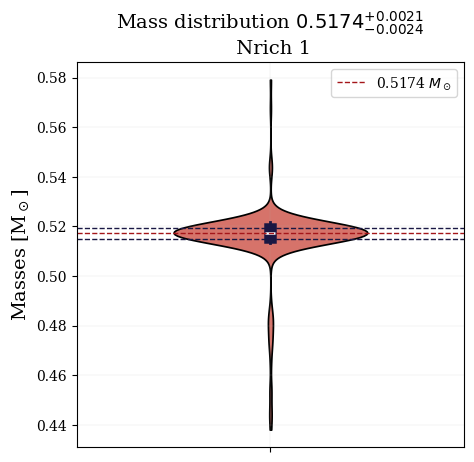

In [52]:
plt.figure(figsize=(5,5))


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]
percentile_16_mass = np.percentile(np.array(M2_all), 16)
percentile_84_mass = np.percentile(np.array(M2_all), 84)

# Calcular el error estimado (asimétrico)
error_lower_mass = (peak_value - percentile_16_mass)
error_upper_mass = (percentile_84_mass - peak_value)

#print("El pico más alto de la distribución está en:", peak_value)

#plt.axhline(y=M2.value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(float(M2.value),3)} $M_\odot$')
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Nrich 1", fontsize = 14)
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

In [50]:
# Nombre del archivo
nombre_archivo = 'Mass_dist_Nrich1.csv'

# Escribir la lista en un archivo .csv
with open(nombre_archivo, mode='w', newline='') as archivo:
    escritor_csv = csv.writer(archivo)
    for elemento in M2_all:
        escritor_csv.writerow([elemento])

print(f"Lista guardada en {nombre_archivo}")

Lista guardada en Mass_dist_Nrich1.csv


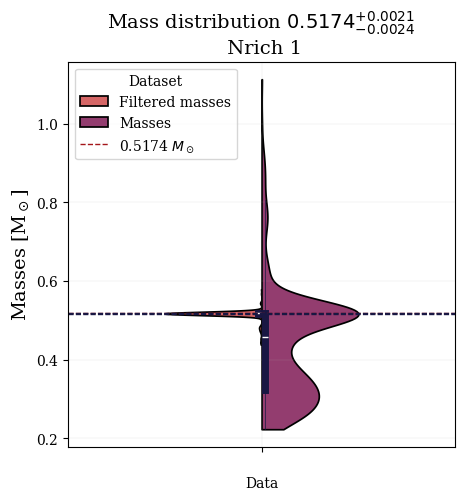

In [53]:
# Crear un DataFrame con las dos listas de datos
plt.figure(figsize=(5,5))

data = pd.DataFrame({
    'Value': M2_all + M2_all_full,
    'Dataset': ['Filtered masses'] * len(M2_all) + ['Masses'] * len(M2_all_full),
    'Data': ['  '] * len(M2_all) + ['  '] * len(M2_all_full)
})

# Crear el diagrama de violín con split=True usando la columna 'Category' para dividir los lados
sns.violinplot(x='Data', y='Value', hue='Dataset', data=data,inner_kws=dict(box_width=5, whis_width=0.5, color="#191743"),
               saturation=0.85, fill=True, inner='box', split=True, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False, palette = "flare")

# Ajustar el gráfico para que se vea mejor
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Nrich 1", fontsize = 14)

plt.legend(loc='upper left',title='Dataset')
plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
#plt.ylim(5,40)
plt.grid(linestyle='-', linewidth=0.1)
# Mostrar el gráfico
plt.show()

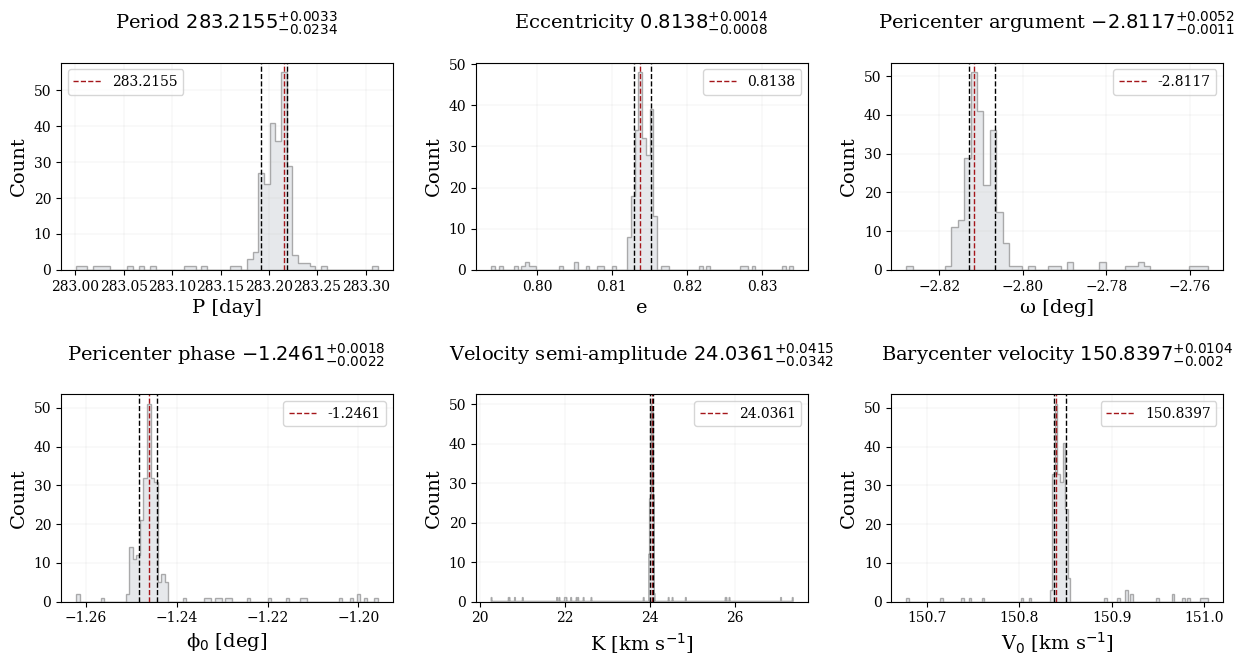

In [54]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado[variables[i]], bins = "auto", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado[variables[i]].value, bins="auto", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

### <span style="color:red"> Análisis de la estrella </span>

De todos los objetos analizados en este trabajo, este TYC 4686-2039-1 es el que nos presenta un resultado más interesante, con 8 épocas de velocidad radial, encontramos que son datos informativos, puesto que el muetreo se vuelve efectivamente unimodal pero demasiado escaso, en este caso entonces se sigue el muestreo de rechazo con MCMC estándar, a partir de aquí se obtuvieron resultados interesantes de masas, asumiendo entonces para la estrella visible una masa de $0.8 M_\odot$ la masa cálculada para el segundo objeto sería de $0.5174^{+0.0021}_{-0.0024} M_\odot$, que realmente nos habla de una compañera binaria, debe ser una estrella compacta debido a que no se puede ver en su espectro, por tanto podemos estar hablando de una enana blanca, se conocen enanas blancas desde $0.1729$ hasta $1.3330$ $M_\odot$, aunque la gran mayoría de ellas se encuentra entre $0.5$ y $0.7~ M_\odot$, con nuestros resultados nos encontramos justo en ese rango de masas, osea que puede tratarse de un objeto de radio cercano al radio de la tierra o bien  $0.009 ~R_\odot$.

El sistema descrito aquí para la órbita sería una de un período de aproximadamente $ P = 283.2155^{+0.0030}_{-0.0234}$ días, con una excentricidad un poco elebada de $e = 0.8138^{+0.0014}_{-0.0008}$, y una semiamplitud de la velocidad de $ K = 24.0361^{+0.0415}_{-0.0342}$ km/s, con una velocidad baricentrica de $150.84^{+0.010}_{-0.002}$ km/s.


La fuente se ve en ultravioleta, óptico, infrarrojo cercano y medio.

<img src="Captura1.png">
<img src="Captura2.png">
<img src="Captura3.png">
<img src="Captura4.png">

### <span style="color:red"> Potencial Binaria </span>  

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305